# anatomix (ICLR'25) tutorial

#### [Paper link](https://arxiv.org/abs/2411.02372) | [GitHub link](https://github.com/neel-dey/anatomix)

In this tutorial, we'll cover how to:
1. Extract 3D features that are approximately stable to modality and appearance changes.
2. Use anatomix features for 3D multimodality registration and **reproduce** our Learn2Reg MRCT results.

If you want to *finetune* the pretrained model for your own datasets or tasks, check out [this tutorial](https://colab.research.google.com/drive/1WBslSRLgAAMq6o5YFif1y0kaW9Ac15XK?usp=sharing) instead.

# Install packages and download demo data

This will take a few minutes.

Make sure to connect to a GPU on Colab. Top right dropdown > Change runtime type > Select a GPU.

# **READ THIS!!!**:
Colab will ask you to restart your runtime the first time that you install the package. Just click the `Restart session` button in the popup and rerun from the top.

In [ ]:
# pip install anatomix and dependencies
import os
!git clone https://github.com/neel-dey/anatomix.git
os.chdir('/content/anatomix')
!pip install -e .
os.chdir('/content/')

In [ ]:
# Download and unzip the Learn2Reg-MRCT multimodality registration challenge
# dataset. This will take 2-3 minutes.

# Learn2RegMRCT comes with images, labels, and foreground masks for both
# abdominal MRI and CT from 8 subjects.

# We will use the images to highlight invariant feature extraction and
# use everything else when performing registration
!wget https://cloud.imi.uni-luebeck.de/s/yiQZfo43YBBg7zL/download/AbdomenMRCT.zip
!unzip /content/AbdomenMRCT.zip

--2025-01-21 06:35:18--  https://cloud.imi.uni-luebeck.de/s/yiQZfo43YBBg7zL/download/AbdomenMRCT.zip
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1916666413 (1.8G) [application/zip]
Saving to: ‘AbdomenMRCT.zip’

AbdomenMRCT.zip     100%[===================>]   1.78G  19.8MB/s    in 94s     

2025-01-21 06:36:53 (19.5 MB/s) - ‘AbdomenMRCT.zip’ saved [1916666413/1916666413]

Archive:  /content/AbdomenMRCT.zip
   creating: AbdomenMRCT/
   creating: AbdomenMRCT/imagesTr/
  inflating: AbdomenMRCT/imagesTr/AbdomenMRCT_1028_0001.nii.gz  
  inflating: AbdomenMRCT/imagesTr/AbdomenMRCT_0001_0000.nii.gz  
  inflating: AbdomenMRCT/imagesTr/AbdomenMRCT_1027_0001.nii.gz  
  inflating: AbdomenMRCT/imagesTr/AbdomenMRCT_0001_0001.nii.gz  
  inflating: AbdomenMRCT/imagesTr/AbdomenMRCT_1029_0001.nii.gz  
  inflating: Ab

# 1. 3D feature extraction using anatomix

In [2]:
import autorootcwd
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from glob import glob

from src.utils.anatomix.model.network import Unet

### Load pretrained model and data and visualize data

In [41]:
# Instantiate model and load pretrained weights

model = Unet(
    dimension=3,  # Only 3D supported for now
    input_nc=1,  # number of input channels
    output_nc=16,  # number of output channels
    num_downs=4,  # number of downsampling layers
    ngf=16,  # channel multiplier
).cuda()

model.load_state_dict(
    torch.load("weight/model-weights/anatomix.pth"),
    strict=True,
)
model.eval()

Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]


Unet(
  (model): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=reflect)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=reflect)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=reflect)
    (7): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=reflect)
    (11): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [28]:
# Get paths to CT images, segmentation labels, and foreground masks:
ct_imgs = sorted(glob('data/imageCAS_heart/test/1000/img.nii.gz'))

In [43]:
def minmax(arr, minclip=None, maxclip=None):
    if not (minclip is None) & (maxclip is None):
        arr = np.clip(arr, minclip, maxclip)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr


# Load and normalize sample CT image from Subject 1
ct = nib.load(ct_imgs[0]).get_fdata()
ct = minmax(ct, minclip=-450, maxclip=450)

print(ct.shape)

(512, 512, 233)


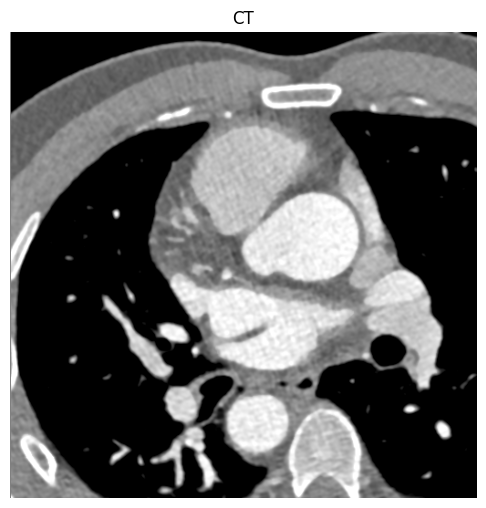

In [34]:
# Visualize a coronal slice from Subject 1
sliceidx = 200

plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(np.rot90(ct[:, :, sliceidx]), cmap='gray')
plt.title('CT')
plt.axis('off')
plt.tight_layout()
plt.show()

### Extract invariant features and visualize outputs

In [ ]:
print(f'Input CT features shape: {ct.shape}')

# Extract 3D features:
with torch.no_grad():
    ct_feats = model(
        torch.from_numpy(ct[np.newaxis, np.newaxis, ...]).float().cuda()
    )

# The pretrained network produces outputs with 16 channels:
print(f'Output CT features shape: {ct_feats.shape}')

#### Extraction invariant features by patch

In [58]:
import numpy as np
import torch
import math

# define patch size (adjust to memory)
patch_size = (128, 128, 64)  # (x, y, z) size

# define patch overlap (reduce boundary effect)
overlap = (16, 16, 8)  # (x, y, z) overlap

# initialize array to store processing results
# output is 16 channels, so (16, x, y, z) size
output_shape = (16,) + ct.shape
result = np.zeros(output_shape, dtype=np.float32)
count = np.zeros(ct.shape, dtype=np.float32)  # how many times each voxel is processed

# calculate patch interval (consider overlap)
stride = tuple(p - o for p, o in zip(patch_size, overlap))

# divide image into patches and process
for z in range(0, ct.shape[2], stride[2]):
    for y in range(0, ct.shape[1], stride[1]):
        for x in range(0, ct.shape[0], stride[0]):
            # calculate patch range
            z_end = min(z + patch_size[2], ct.shape[2])
            y_end = min(y + patch_size[1], ct.shape[1])
            x_end = min(x + patch_size[0], ct.shape[0])
            
            z_start, y_start, x_start = z, y, x
            
            # extract patch
            patch = ct[x_start:x_end, y_start:y_end, z_start:z_end]
            
            # check patch size and pad if necessary
            current_size = patch.shape
            if current_size != patch_size:
                temp_patch = np.zeros(patch_size, dtype=patch.dtype)
                temp_patch[:current_size[0], :current_size[1], :current_size[2]] = patch
                patch = temp_patch
            
            # input patch to model
            with torch.no_grad():
                patch_tensor = torch.from_numpy(patch[np.newaxis, np.newaxis, ...]).float().cuda()
                patch_features = model(patch_tensor)
                
                # move result to CPU and convert to numpy array
                patch_features = patch_features.cpu().numpy()[0]  # remove batch dimension
            
            # crop result to original patch size
            if current_size != patch_size:
                patch_features = patch_features[:, :current_size[0], :current_size[1], :current_size[2]]
            
            # add result to result array
            result[:, x_start:x_end, y_start:y_end, z_start:z_end] += patch_features
            count[x_start:x_end, y_start:y_end, z_start:z_end] += 1

# divide by count to calculate average (handle overlapping parts)
for i in range(16):  # for each channel
    # avoid division by zero
    mask = count > 0
    result[i][mask] /= count[mask]

# check final result
print(f"processing complete! final feature map size: {result.shape}")

# convert to PyTorch tensor
ct_feats = torch.from_numpy(result).float()
print(f"output feature map size: {ct_feats.shape}")

패치 처리 완료: (0:128, 0:128, 0:64)
패치 처리 완료: (112:240, 0:128, 0:64)
패치 처리 완료: (224:352, 0:128, 0:64)
패치 처리 완료: (336:464, 0:128, 0:64)
패딩된 패치: (64, 128, 64) -> (128, 128, 64)
패치 처리 완료: (448:512, 0:128, 0:64)
패치 처리 완료: (0:128, 112:240, 0:64)
패치 처리 완료: (112:240, 112:240, 0:64)
패치 처리 완료: (224:352, 112:240, 0:64)
패치 처리 완료: (336:464, 112:240, 0:64)
패딩된 패치: (64, 128, 64) -> (128, 128, 64)
패치 처리 완료: (448:512, 112:240, 0:64)
패치 처리 완료: (0:128, 224:352, 0:64)
패치 처리 완료: (112:240, 224:352, 0:64)
패치 처리 완료: (224:352, 224:352, 0:64)
패치 처리 완료: (336:464, 224:352, 0:64)
패딩된 패치: (64, 128, 64) -> (128, 128, 64)
패치 처리 완료: (448:512, 224:352, 0:64)
패치 처리 완료: (0:128, 336:464, 0:64)
패치 처리 완료: (112:240, 336:464, 0:64)
패치 처리 완료: (224:352, 336:464, 0:64)
패치 처리 완료: (336:464, 336:464, 0:64)
패딩된 패치: (64, 128, 64) -> (128, 128, 64)
패치 처리 완료: (448:512, 336:464, 0:64)
패딩된 패치: (128, 64, 64) -> (128, 128, 64)
패치 처리 완료: (0:128, 448:512, 0:64)
패딩된 패치: (128, 64, 64) -> (128, 128, 64)
패치 처리 완료: (112:240, 448:512, 0:64)
패딩된 패치: (1

: 

torch.Size([16, 512, 512, 233])


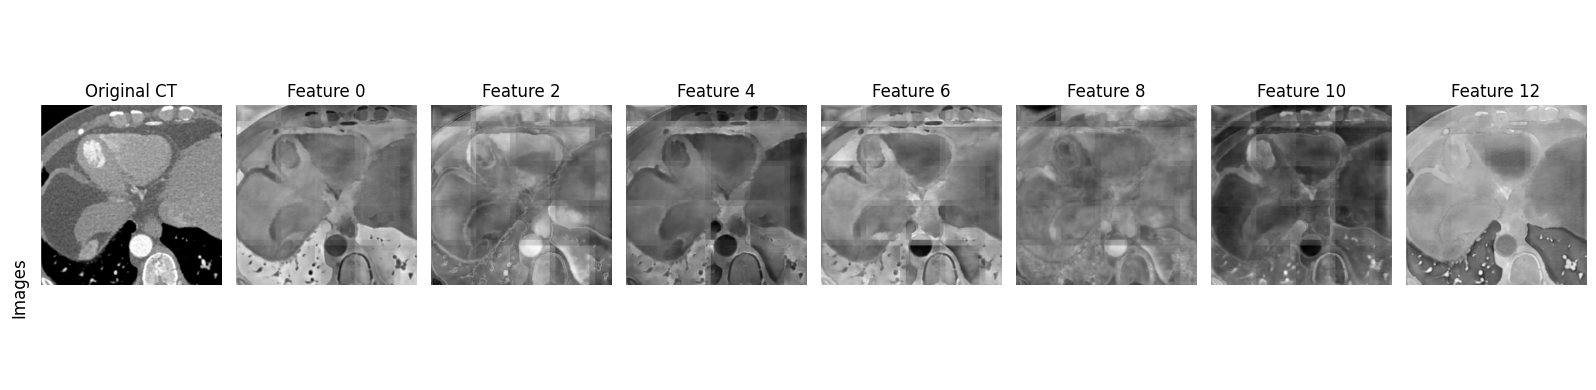

In [56]:
sliceidx = 60

print(ct_feats.shape)

plt.figure(figsize=(16, 4))


plt.text(-0.02, 0.25, 'Images', fontsize=12, va='center', rotation=90)
plt.axis('off')

# original image
plt.subplot(1, 8, 1)
plt.imshow(np.rot90(ct[:, :, sliceidx]), cmap='gray')
plt.axis('off')
plt.title('Original CT')

# feature maps
for i in range(7):
    plt.subplot(1, 8, i + 2)
    plt.imshow(
        np.rot90(ct_feats[i * 2, :, :, sliceidx].cpu().numpy()),
        cmap='gray',
    )
    plt.axis('off')
    plt.title(f'Feature {i * 2}')

plt.tight_layout()
plt.show()

# 2. Multimodality registration using anatomix

We're going to do intrasubject registration on Learn2RegMRCT by registering the MRIs to the CTs.

In [ ]:
# Load registration module
# We use a heavily modified fork of the convexadam repository as our solver here
from anatomix.registration import convex_adam

**NOTE FOR OTHER DATASETS**: The convexadam solver requires careful tuning of registration hyperparameters. The settings here were found via grid search on Subject 1 (index 0) of this dataset (our validation subject). It is likely that your own dataset will require other convexadam hyperparameters.

### Reproduce Learn2Reg-AbdomenMRCT results

#### Compute registrations

In [ ]:
# Create scratch output directory
os.makedirs('./demo', exist_ok=True)

# Loop over all subjects and save outputs to disk:
for i in range(8):
    # TODO: write a batch mode convexadam function that takes lists of file
    # paths as input. PRs welcome!
    convex_adam(
        ckpt_path='./anatomix/model-weights/anatomix.pth',
        expname='demo',
        result_path='./demo/',
        lambda_weight=0.75,
        grid_sp=2,
        disp_hw=1,
        selected_niter=80,
        selected_smooth=0,
        grid_sp_adam=2,
        ic=True,
        use_mask=True,
        warp_seg=True,
        fixed_image=ct_imgs[i],
        fixed_mask=ct_masks[i],
        fixed_seg=ct_labels[i],
        fixed_minclip=-450,
        fixed_maxclip=450,
        moving_image=mr_imgs[i],
        moving_mask=mr_masks[i],
        moving_seg=mr_labels[i],
    )

Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  1.7896158695220947
Dice: 0.8757196827967242
Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  1.7009291648864746
Dice: 0.1453067357317416
Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  1.6947121620178223
Dice: 0.7369871314476238
Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  1.6981110572814941
Dice: 0.9041192666577049
Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  1.7901723384857178
Dice: 0.8955794240298192
Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44

#### Compute test set results

In [ ]:
predictions = sorted(glob('./demo/labels_moved*.nii.gz'))
gts = sorted(glob('./AbdomenMRCT/labelsTr/*_0001.nii.gz'))[:8]

assert len(predictions) == len(gts)

# Compute test set results:
dices = np.zeros(len(predictions))

for i in range(len(predictions)):
    pred = nib.load(predictions[i]).get_fdata()
    gt = nib.load(gts[i]).get_fdata()
    dices[i] = f1_score(
        y_true=gt.flatten().astype(np.uint8),
        y_pred=pred.flatten().astype(np.uint8),
        average='macro',
        labels=np.unique(gt.flatten())[1:],
    )

# In our paper, we tuned the hyperparameters on subject 1 and tested on the
# remaining seven
print(f'Test set median Dice: {np.median(dices[1:])}')

Test set median Dice: 0.8329047901248192


#### Visualize registration results

In [ ]:
def load_nifti_for_viz(fpath):
    nii = nib.load(fpath)
    arr = nii.get_fdata().squeeze()
    return arr

# Sample arbitrary subject index
subj_idx = 5

# Load input fixed and moving volumes
fixed_ct = load_nifti_for_viz(ct_imgs[subj_idx])
fixed_ct = minmax(fixed_ct, minclip=-450, maxclip=450)

moving_mr = load_nifti_for_viz(mr_imgs[subj_idx])
moving_mr = minmax(moving_mr)

# Load computed moved mri and displacement field
moved_imgs = sorted(glob('./demo/moved*.nii.gz'))
moved_mr = load_nifti_for_viz(moved_imgs[subj_idx])
moved_mr = minmax(moved_mr)

moved_disp = load_nifti_for_viz(
    predictions[subj_idx].replace('labels_moved', 'disp')
)
# Displacement field's a (x, y, z, 3) array, we use its norm for viz
moved_disp = minmax(np.linalg.norm(moved_disp, axis=-1))

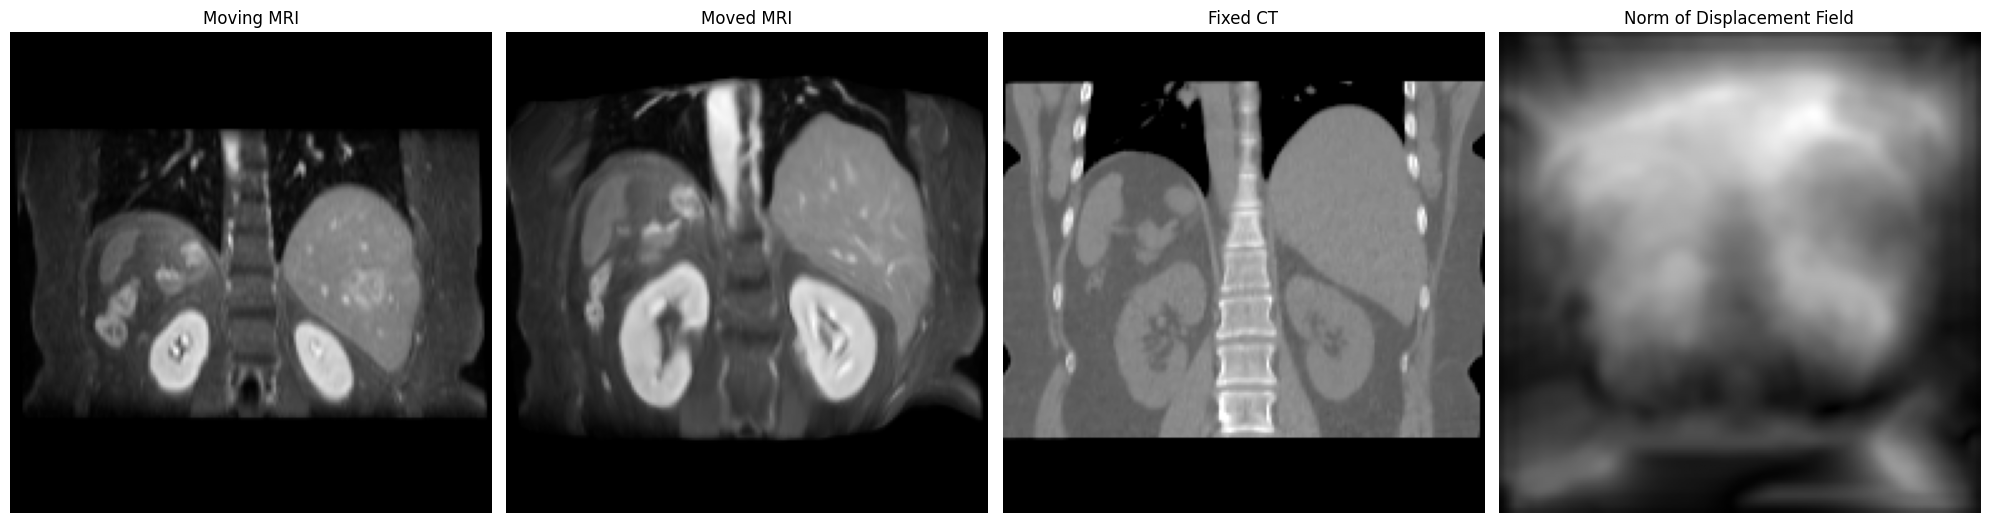

In [ ]:
# Visualize a coronal slice from Subject 1

sliceidx = 62

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(np.rot90(moving_mr[:, sliceidx, ...]), cmap='gray')
plt.title('Moving MRI')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(np.rot90(moved_mr[:, sliceidx, ...]), cmap='gray')
plt.title('Moved MRI')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(np.rot90(fixed_ct[:, sliceidx, ...]), cmap='gray')
plt.title('Fixed CT')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(np.rot90(moved_disp[:, sliceidx, ...]), cmap='gray')
plt.title('Norm of Displacement Field')
plt.axis('off')
plt.tight_layout()
plt.show()


### CLI interface

If you want to use anatomix with convexadam from the command line, you can provide input volume niftis as below.

Use `!python anatomix/anatomix/registration/run_convex_adam_with_network_feats.py -h` to see the full CLI interface.

In [ ]:
# Create scratch output directory
os.makedirs('./cli_demo/', exist_ok=True)

!python anatomix/anatomix/registration/run_convex_adam_with_network_feats.py \
--ckpt_path ./anatomix/model-weights/anatomix.pth \
--exp_name withmask \
--fixed_minclip -450 \
--fixed_maxclip 450 \
--use_mask \
--result_path ./cli_demo/ \
--warp_seg \
--fixed /content/AbdomenMRCT/imagesTr/AbdomenMRCT_0001_0001.nii.gz \
--moving /content/AbdomenMRCT/imagesTr/AbdomenMRCT_0001_0000.nii.gz \
--path_mask_fixed /content/AbdomenMRCT/masksTr/AbdomenMRCT_0001_0001.nii.gz \
--path_mask_moving /content/AbdomenMRCT/masksTr/AbdomenMRCT_0001_0000.nii.gz \
--path_seg_fixed /content/AbdomenMRCT/labelsTr/AbdomenMRCT_0001_0001.nii.gz \
--path_seg_moving /content/AbdomenMRCT/labelsTr/AbdomenMRCT_0001_0000.nii.gz

2025-01-20 22:34:27.777828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 22:34:27.797945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 22:34:27.804160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 22:34:29.079823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  1.928328275680542
Dice: 0.8758862828964441
